In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

tf.VERSION

W0411 08:18:17.375841  6160 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


'1.13.1'

In [2]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 20s 0us/step


In [30]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))

C:\Users\axel\.keras\datasets\flower_photos
Found 3670 images belonging to 5 classes.


In [4]:
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 256, 256, 3)
Labe batch shape:  (32, 5)


In [5]:
classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2" #@param {type:"string"}

In [6]:
def classifier(x):
  classifier_module = hub.Module(classifier_url)
  return classifier_module(x)
  
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))



Instructions for updating:
Colocations handled automatically by placer.


W0411 08:20:33.814055  6160 deprecation.py:323] From c:\users\axel\kamai\flower-image-classification\venv\lib\site-packages\tensorflow\python\ops\control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [7]:
classifier_layer = layers.Lambda(classifier, input_shape = IMAGE_SIZE+[3])
classifier_model = tf.keras.Sequential([classifier_layer])
classifier_model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0411 08:20:38.383055  6160 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [8]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


In [9]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

In [10]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SIZE)
grace_hopper 

grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

65536/61306 [================================] - 0s 0us/step


(224, 224, 3)

16384/10484 [==============================================] - 0s 0us/step


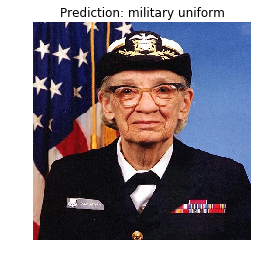

In [11]:
result = classifier_model.predict(grace_hopper[np.newaxis, ...])
result.shape

predicted_class = np.argmax(result[0], axis=-1)
predicted_class

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name)

In [12]:
result_batch = classifier_model.predict(image_batch)

In [13]:
labels_batch = imagenet_labels[np.argmax(result_batch, axis=-1)]
labels_batch

array(["yellow lady's slipper", 'daisy', 'maze', 'vase', 'cardoon',
       'vase', 'picket fence', 'daisy', 'cardoon', 'cardoon', 'quill',
       'vase', 'bakery', 'daisy', 'quill', 'bee', 'handkerchief',
       'picket fence', 'studio couch', 'mushroom', 'mailbox', 'palace',
       'sea urchin', 'daisy', "yellow lady's slipper", 'daisy', 'cup',
       'picket fence', 'daisy', 'harvester', 'picket fence', 'daisy'],
      dtype='<U30')

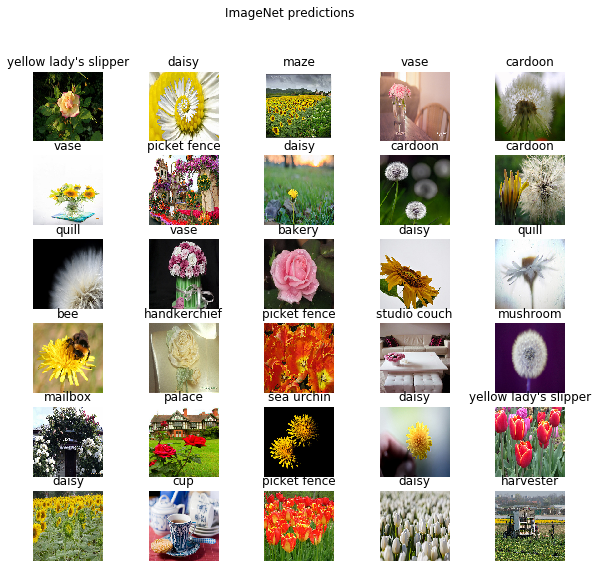

In [14]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [15]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" #@param {type:"string"}

In [16]:
def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

In [17]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


In [18]:
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])

In [19]:
features_extractor_layer.trainable = False

In [20]:
model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0411 08:22:43.707112  6160 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 6,405
Trainable params: 6,405
Non-trainable params: 0
_________________________________________________________________


In [21]:
init = tf.global_variables_initializer()
sess.run(init)

In [22]:
result = model.predict(image_batch)
result.shape

(32, 5)

In [23]:
model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [24]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])

In [25]:
steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=1, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])

Instructions for updating:
Use tf.cast instead.


W0411 08:22:48.887085  6160 deprecation.py:323] From c:\users\axel\kamai\flower-image-classification\venv\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


114/114 [==============================] - 74s 647ms/step - loss: 0.6542 - acc: 0.7633


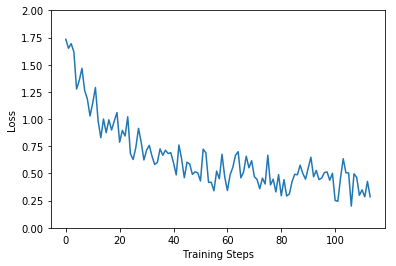

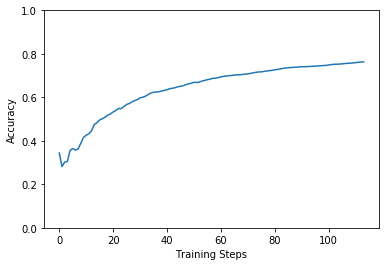

In [26]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)

In [27]:
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [28]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Daisy', 'Roses', 'Dandelion', 'Sunflowers', 'Daisy', 'Dandelion',
       'Dandelion', 'Dandelion', 'Tulips', 'Roses', 'Dandelion', 'Daisy',
       'Daisy', 'Daisy', 'Dandelion', 'Dandelion', 'Tulips', 'Dandelion',
       'Sunflowers', 'Daisy', 'Dandelion', 'Tulips', 'Roses', 'Tulips',
       'Dandelion', 'Dandelion', 'Tulips', 'Dandelion', 'Daisy', 'Tulips',
       'Roses', 'Sunflowers'], dtype='<U10')

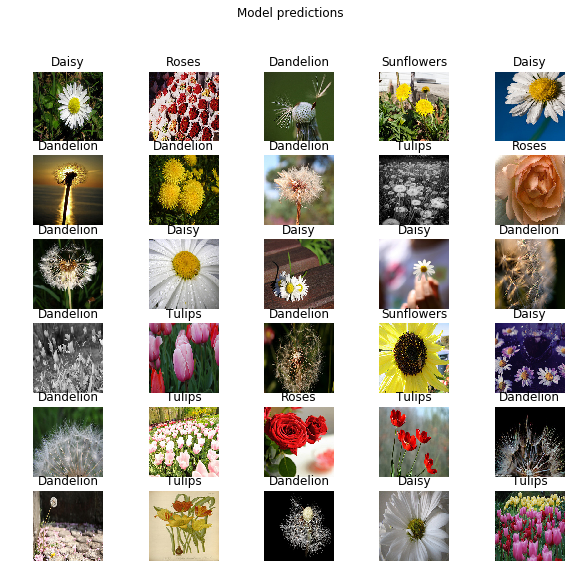

In [29]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")